In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import BallTree
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, LineString
from pyproj import Proj, transform
from choicemodels.tools.distancematrix import distance_matrix
# from scipy.spatial import distance_matrix
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
import orca
import os; os.chdir('../')
import warnings;warnings.simplefilter('ignore')

/home/max/anaconda3/envs/ual-model/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Load data

In [6]:
data_dir = '/home/data/'
chts_dir = 'CHTS_csv_format/'

In [7]:
chts_persons = pd.read_csv(data_dir + chts_dir + 'data/Deliv_PER.csv', low_memory=False)

In [5]:
chts_persons_lookup = pd.read_csv(data_dir + chts_dir + 'data/LookUp_PER.csv')

In [6]:
chts_households_lookup = pd.read_csv(data_dir + chts_dir + 'data/LookUp_Home.csv')

In [7]:
chts_persons = pd.merge(
    chts_persons.set_index(['SAMPN','PERNO']),
    chts_persons_lookup.set_index(['SAMPN','PERNO']),
    left_index=True, right_index=True,
    suffixes=('_persons', '_lookup')).reset_index()

chts_persons = pd.merge(
    chts_persons.set_index(['SAMPN']),
    chts_households_lookup.set_index(['SAMPN']),
    left_index=True, right_index=True).reset_index()

chts_persons = chts_persons[chts_persons['HCTFIP'].isin([1, 13, 41, 55, 75, 81, 85, 95, 97])].reset_index()

In [3]:
orca.add_injectable('data_directory', '/home/data/2018-07/')

from scripts import datasources
from scripts import models

In [4]:
jobs = orca.get_table('jobs').to_frame()

In [5]:
buildings = orca.get_table('buildings').to_frame()

In [6]:
parcels = orca.get_table('parcels').to_frame()

### Identify in-region workers

In [12]:
chts_persons['work_in_region'] = chts_persons['WCTFIP_lookup'].isin([1, 13, 41, 55, 75, 81, 85, 95, 97])

In [13]:
chts_persons['work_in_region'].value_counts()

False    13810
True     10220
Name: work_in_region, dtype: int64

### Get job coords

In [7]:
buildings = pd.merge(buildings, parcels[['x', 'y']], left_on='parcel_id', right_index=True)
jobs = pd.merge(jobs, buildings[['x', 'y']], left_on='building_id', right_index=True)
jobs.rename(columns={'x': 'lng', 'y': 'lat'}, inplace=True)

### Prepare jobs table and CHTS persons table for job assignment

In [15]:
jobs.loc[:,'taken'] = False

In [16]:
chts_persons.loc[:, 'job_id'] = None

In [17]:
# haversine requires data in form of [lat, lng] and inputs/outputs in units of radians
persons_work_rad = np.deg2rad(chts_persons[['WYCORD_lookup', 'WXCORD_lookup']])
jobs_rad = np.deg2rad(jobs[['lng', 'lat']])
jobs.loc[:, 'x'] = jobs_rad['lng']
jobs.loc[:, 'y'] = jobs_rad['lat']

### Assign CHTS persons a job ID

In [30]:
dists = []
no_job_info = []
no_work_coords = []

for i, person in tqdm(chts_persons.iterrows(), total=len(chts_persons)):
    # only assign a job ID for employed persons with a fixed
    # work location other than their home
    if (person['EMPLY'] == 1) & (person['WLOC'] == 1) & (person['work_in_region'] == True):
        
        # skip person if no CHTS industry or occupation
        if (person['INDUS'] > 96) & (person['OCCUP'] > 96):
            no_job_info.append(i)
            continue
        
        # skip person if no work location
        elif pd.isnull(person[['WYCORD_lookup', 'WXCORD_lookup']]).any():
            no_work_coords.append(i)
            continue
        
        # if CHTS industry is unknown, match jobs based on occupation only
        elif person['INDUS'] > 96:
            potential_jobs = jobs[
                (jobs['occupation_id'] == person['OCCUP']) &
                (jobs['taken'] == False)]
        
        # if occupation is unknown, match jobs based on industry only
        elif person['OCCUP'] > 96:
            potential_jobs = jobs[
                (jobs['sector_id'] == person['INDUS']) &
                (jobs['taken'] == False)]
        
        elif (person['INDUS'] < 97) & (person['OCCUP'] < 97):
            
            # define potential jobs based on industry and occupation
            potential_jobs = jobs[
                (jobs['sector_id'] == person['INDUS']) &
                (jobs['occupation_id'] == person['OCCUP']) &
                (jobs['taken'] == False)]
            
            # if no such jobs exist, define jobs by industry
            if len(potential_jobs) == 0:
                potential_jobs = jobs[
                    (jobs['sector_id'] == person['INDUS']) &
                    (jobs['taken'] == False)]
                
            # if no such jobs exist, define jobs by occupation
            if len(potential_jobs) == 0:
                potential_jobs = jobs[
                    (jobs['occupation_id'] == person['OCCUP']) &
                    (jobs['taken'] == False)]
            
            # otherwise, continue
            if len(potential_jobs) == 0:
                continue
        
        # build the tree of potential jobs for fast nearest-neighbor search
        tree = BallTree(potential_jobs[['y','x']], metric='haversine')
        
        # query the tree for nearest job to each workplace
        dist, idx = tree.query(persons_work_rad.iloc[i].values.reshape(1,-1), return_distance=True)
        
        # save results
        job = potential_jobs.iloc[idx[0]]
        dists.append(dist[0][0])
        chts_persons.loc[i, 'job_id'] = job.index.values[0]
        jobs.loc[jobs.index.values == job.index.values[0], 'taken'] = True 


100%|██████████| 24030/24030 [34:31<00:00, 11.60it/s]


In [60]:
persons_rad.iloc[2].values

array([ 0.65923277, -2.1363285 ])

In [31]:
print('Assigned job IDs to {0}% of workers with a fixed work location.'.format(
    np.round(chts_persons.job_id.count() / len(
        chts_persons[(chts_persons['EMPLY'] == 1)  & (chts_persons['WLOC'] == 1)]) * 100, 1)))
print('{0}% had no industry/occupation info.'.format(
    np.round(len(no_job_info) / len(
        chts_persons[(chts_persons['EMPLY'] == 1)  & (chts_persons['WLOC'] == 1)]) * 100, 1)))
print('{0}% had no work coordinates.'.format(
    np.round(len(no_work_coords) / len(
        chts_persons[(chts_persons['EMPLY'] == 1)  & (chts_persons['WLOC'] == 1)]) * 100, 1)))

Assigned job IDs to 96.5% of workers with a fixed work location.
1.7% had no industry/occupation info.
0.0% had no work coordinates.


In [38]:
km_dists = [dist * 6371 for dist in dists]

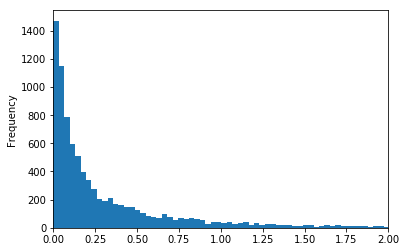

In [41]:
pd.Series(km_dists).plot(kind='hist', bins=1000, xlim=(0, 2.5))

In [43]:
chts_persons.to_csv('chts_persons_w_jobs.csv', index=False)

In [8]:
chts_persons = pd.read_csv('chts_persons_w_jobs.csv')

### Assign CHTS persons to buildings

In [17]:
persons_home_rad = np.deg2rad(chts_persons[['HYCORD', 'HXCORD']])
bldg_rad = np.deg2rad(buildings[['y', 'x']])

buildings.loc[:, 'x_rad'] = bldg_rad['x']
buildings.loc[:, 'y_rad'] = bldg_rad['y']

In [19]:
tree = BallTree(buildings[['y_rad','x_rad']], metric='haversine')

In [20]:
dists, idxs = tree.query(persons_home_rad, return_distance=True)

In [21]:
km_dists = pd.Series([dist[0] * 6371 for dist in dists])

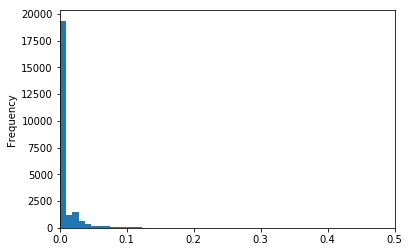

In [22]:
pd.Series(km_dists).plot(kind='hist', bins=100, xlim=(0,0.5))

In [23]:
chts_persons['building_id'] = buildings.iloc[idxs[:,0]].index

In [24]:
orca.add_table('chts_persons', chts_persons)

In [25]:
orca.broadcast('buildings', 'chts_persons', cast_index=True, onto_on='building_id')

### Generate Accessibility Vars

In [26]:
%%time
orca.run(['initialize_network_small', 'network_aggregations_small'])

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 7.73 s
Running step 'network_aggregations_small'
Computing accessibility variables
Computing units_10000
Computing units_sf_10000
Computing units_mf_10000
Computing pop_10000
Removed 189769 rows because they contain missing values
Computing hh_10000
Removed 189769 rows because they contain missing values
Computing poor_10000
Removed 53114 rows because they contain missing values
Computing renters_10000
Removed 102597 rows because they contain missing values
Computing avg_income_10000
Removed 189769 rows because they contain missing values
Computing jobs_10000
Computing avg_rent_10000
Computing pop_white_10000
Removed 107372 rows because they contain missing values
Computing pop_black_10000
Removed 10541 rows because they contain missing values
Computing pop_asian_10000
Removed 51048 rows because they contain missing values
Computing pop_hisp_10000
Removed 31685 rows because they contain missing val

In [27]:
%%time
orca.run(['initialize_network_walk','network_aggregations_walk'])

Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 20.62 s
Running step 'network_aggregations_walk'
Computing accessibility variables
Computing units_500_walk
Computing sqft_unit_500_walk
Computing singles_500_walk
Removed 52084 rows because they contain missing values
Computing elderly_hh_500_walk
Removed 34553 rows because they contain missing values
Computing children_500_walk
Removed 189769 rows because they contain missing values
Computing units_sf_500_walk
Computing units_mf_500_walk
Computing pop_500_walk
Removed 189769 rows because they contain missing values
Computing hh_500_walk
Removed 189769 rows because they contain missing values
Computing poor_500_walk
Removed 53114 rows because they contain missing values
Computing rich_500_walk
Removed 38964 rows because they contain missing values
Computing renters_500_walk
Removed 102597 rows because they contain missing values
Computing avg_income_500_walk
Removed 189769 rows because they contain 

### List data tables, columns, and merge relationships

In [112]:
for table_name in orca.list_tables():
    print(table_name.upper())
    print(orca.get_table(table_name).to_frame().columns.tolist())
    print()

PARCELS
['development_type_id', 'land_value', 'acres', 'county_id', 'zone_id', 'proportion_undevelopable', 'tax_exempt_status', 'apn', 'parcel_id_local', 'geom_id', 'imputation_flag', 'x', 'y', 'shape_area', 'block_id', 'node_id', 'node_id_small', 'node_id_walk']

BUILDINGS
['parcel_id', 'development_type_id', 'improvement_value', 'residential_units', 'residential_sqft', 'sqft_per_unit', 'non_residential_sqft', 'building_sqft', 'nonres_rent_per_sqft', 'res_price_per_sqft', 'stories', 'year_built', 'redfin_sale_price', 'redfin_sale_year', 'redfin_home_type', 'costar_property_type', 'costar_rent', 'building_type_id', 'res_sqft_per_unit', 'node_id_small', 'node_id_walk']

CRAIGSLIST
['date', 'region', 'neighborhood', 'rent', 'bedrooms', 'sqft', 'rent_sqft', 'longitude', 'latitude', 'county', 'fips_block', 'state', 'bathrooms']

RENTALS
['Unnamed: 0', 'date', 'region', 'neighborhood', 'rent', 'bedrooms', 'sqft', 'rent_sqft', 'longitude', 'latitude', 'county', 'fips_block', 'state', 'bathro

In [8]:
orca.list_broadcasts()

[('parcels', 'buildings'),
 ('buildings', 'units'),
 ('units', 'households'),
 ('households', 'persons')]

In [11]:
orca.broadcast('buildings', 'jobs', cast_index=True, onto_on='building_id')

### tract-to-tract distance matrix

In [38]:
tract_geoms = gpd.read_file('notebooks-max/tl_2010_06_tract10.shp')

In [45]:
tract_geoms.to_crs({'init':'epsg:26910'}, inplace=True)

In [46]:
tract_geoms['x'] = tract_geoms.centroid.x
tract_geoms['y'] = tract_geoms.centroid.y

In [51]:
data = tract_geoms[['GEOID10', 'x', 'y']].set_index('GEOID10')

In [52]:
%%time
dm = distance_matrix(data, x='x', y='y')
dm.index.set_names(('home_tract', 'work_tract'), inplace=True)
dm = dm.rename('distance').to_frame()

CPU times: user 5.08 s, sys: 2.37 s, total: 7.46 s
Wall time: 2.63 s


In [53]:
dm.head()

distance
home_tract  work_tract              
06083002103 06083002103     0.000000
            06083002402  3699.332629
            06083002102  1262.585664
            06083002010  6764.024701
            06083002009  6486.302663

In [12]:
parcel_attrs = pd.read_csv('/home/data/2018-07/mtc_data_platform_format_7-6-18/parcel_attr.csv', dtype={'block_id':str})

In [13]:
parcel_attrs['tract_id'] = parcel_attrs['block_id'].str[0:11]

In [17]:
tracts = parcel_attrs[['tract_id', 'x', 'y']].drop_duplicates(['tract_id']).set_index('tract_id')

In [19]:
tracts['geometry'] = [Point(xy) for xy in tracts[['x', 'y']].values]

In [22]:
gdf = gpd.GeoDataFrame(tracts, geometry='geometry')

In [24]:
gdf.crs = {'init': 'epsg:4326'}

In [25]:
gdf = gdf.to_crs({'init': 'epsg:26910'})

In [26]:
gdf['x_proj'] = [pt.xy[0][0] for pt in gdf['geometry']]
gdf['y_proj'] = [pt.xy[1][0] for pt in gdf['geometry']]

In [27]:
data = pd.DataFrame(gdf[['x_proj','y_proj']])

In [28]:
%%time
dm = distance_matrix(data, x='x_proj', y='y_proj')

CPU times: user 181 ms, sys: 24.1 ms, total: 205 ms
Wall time: 79.3 ms


In [30]:
dm.index.set_names(('home_tract', 'work_tract'), inplace=True)
dm = dm.rename('distance').to_frame()

In [33]:
parcels.head()

,development_type_id,land_value,acres,county_id,zone_id,proportion_undevelopable,tax_exempt_status,apn,parcel_id_local,geom_id,imputation_flag,x,y,shape_area,block_id,node_id,node_id_small,node_id_walk
primary_id,,,,,,,,,,,,,,,,,,
229116,1,0.0,3.360520,1,725,0.0,0,099 029001700,,10305106092872,_,-121.795620,37.655379,1.359956e+04,060014511022061,53091636,53103254,53091636
244166,1,0.0,1.294423,1,715,0.0,0,099B540210200,,11107351665227,_,-121.713004,37.717277,5.238348e+03,060014511011025,53059159,53026359,53059159
202378,25,6036500.0,14.993605,1,820,0.0,1,085A643106000,,11030175960628,merged,-122.014199,37.655260,6.067702e+04,060014351031029,1852532916,1706630465,1852532916
2004420,-1,179954.0,316.247146,97,1401,0.0,0,141-100-012,,6381677629073,"_, nr_zone_yrblt, bsqft_from_nrsqft, stories1",-122.771868,38.727893,1.279808e+06,060971541003180,4533108955,4533108955,3749542723
340332,2,0.0,0.621275,1,763,0.0,0,525 166004800,,314875459798,_,-121.974508,37.546277,2.514215e+03,060014419272014,443532766,1666841915,2397935818


In [31]:
dm.head()

distance
home_tract  work_tract                
06001451102 06001451102       0.000000
            06001451101   10012.516344
            06001435103   19282.301491
            06097154100  146531.235653
            06001441927   19898.537208

### Estimate ELCM for retail workers with fixed work location other than their home

In [123]:
m = LargeMultinomialLogitStep()
m.name = 'WLCM'

In [124]:
m.choosers = ['chts_persons']
# chooser_ids = orca.get_table('jobs').to_frame().sample(15000).index.values
m.alternatives = ['jobs', 'buildings', 'parcels', 'nodessmall', 'nodeswalk']
m.choice_column = 'job_id'

In [126]:
m.alt_sample_size = 50
m.chooser_filters = ['EMPLY == 1', 'WLOC == 1', 'work_in_region == True', 'INDUS in [44,45]']
m.alt_filters = ['0 < avg_income_10000 < 500000', 'sector_id in [44,45]']

In [139]:
m.model_expression = ('np.log1p(jobs_1500_walk_retail) + np.log(units_10000) + np.log1p(pop_1500_walk)')
m.name = 'elcm'
m.tags = ['max', 'test']
m.fit()

                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:               
Model:         Multinomial Logit   Df Residuals:                   
Method:       Maximum Likelihood   Df Model:                       
Date:                              Pseudo R-squ.:                  
Time:                              Pseudo R-bar-squ.:              
AIC:                               Log-Likelihood:       -2,771.909
BIC:                               LL-Null:              -2,801.008
                                     coef   std err         z     P>|z|   Conf. Int.
------------------------------------------------------------------------------------
Intercept                         -0.0000     0.524    -0.000                       
np.log1p(jobs_1500_walk_retail)   -0.0576     0.030    -1.890                       
np.log(units_10000)               -0.1723     0.040    -4.340                       
np.log1p(pop_1500_walk)        